<a href="https://colab.research.google.com/github/lakshanravi/langgraph-workflow-agents/blob/main/langgraph_stage_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install langgraph -q

### Simple Graph ( Single input + Multiple inputs )

In [7]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

#START is a special built-in node.It represents Where execution begins.

In [8]:
#AgentState is not a normal class.It defines the expected structure of a dictionary.The dictionary must contain: name → string,message → string.  Type checking
#TypedDict defines structure. Otherwise we can give any values to the dic no.
class AgentState(TypedDict):
    name : str
    message : str

# class AgentState(TypedDict):
#     name : str
#     age : int
#     message : str

#below fuction receives a dictionary (state) with keys name and message. modifies the message field.It returns the updated dictionary.
def introduce(state: AgentState) -> AgentState:
    state['message'] = f"""My name is {state["name"]}."""
    return state

# def introduce(state: AgentState) -> AgentState:
#     state['message'] = f"""My name is {state["name"]}. I'm {state["age"]} years old."""
#     return state

In [9]:
#StateGraph = workflow builder | START = entry point | END = exit point
workflow = StateGraph(AgentState)

#below we create new node called introduce. and we set function introduce to that as act
#“When the graph reaches the node named introduce, run this function.”
workflow.add_node("introduce", introduce)
#draw edge from start node to introduce node
workflow.add_edge( START, "introduce" )
#draw edge from introduce node to end node
workflow.add_edge( "introduce", END )
#compiling the workflow
app = workflow.compile()

# **Display created graph.**

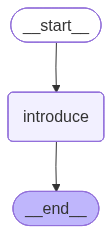

In [10]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
#now we can use above workflow (app).
#The workflow executes the introduce function
result = app.invoke({"name": "Lakshan"})
print(result)

{'name': 'Lakshan', 'message': 'My name is Lakshan.'}


In [12]:
print(result["message"])

My name is Lakshan.


In [16]:
# result = app.invoke({"name": "Lakshan", "age":20})
# print(result)

In [ ]:
# print(result["message"])

### Sequential Graph

In [13]:
from typing import TypedDict
from langgraph.graph import StateGraph

In [14]:
class AgentState(TypedDict):
    name: str
    age: int
    message: str

In [32]:
#here we create two functions for two different nodes
def introduce_name(state:AgentState) -> AgentState:
    state["message"] = f"""My name is {state["name"]}."""
    return state

def introduce_age(state:AgentState) -> AgentState:
    state["message"] = state["message"] + f"""I'm {state["age"]} years old."""
    return state



In [33]:
#Every node must return AgentState (which is a dict)
workflow = StateGraph(AgentState)

workflow.add_node("introduce_name", introduce_name)
workflow.add_node("introduce_age", introduce_age)

workflow.add_edge( START, "introduce_name" )
workflow.add_edge( "introduce_name", "introduce_age" )
workflow.add_edge( "introduce_age", END )

app = workflow.compile()

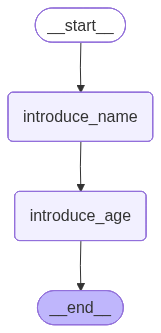

In [34]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [35]:
result = app.invoke({"name": "Kamal", "age": 20})
print(result)

{'name': 'Kamal', 'age': 20, 'message': "My name is Kamal.I'm 20 years old."}


In [36]:
print(result["message"])

My name is Kamal.I'm 20 years old.


### Conditional Graph

In [37]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

In [38]:
class AgentState(TypedDict):
    num1: int
    num2: int
    operation: str
    result: int

In [40]:
def addition(state:AgentState) -> AgentState:
    state["result"] = state["num1"] + state["num2"]
    return state

def subtraction(state:AgentState) -> AgentState:
    state["result"] = state["num1"] - state["num2"]
    return state

def multiplication(state:AgentState) -> AgentState:
    state["result"] = state["num1"] * state["num2"]
    return state

def division(state:AgentState) -> AgentState:
    state["result"] = state["num1"] / state["num2"]
    return state


def decision_node(state:AgentState) -> AgentState:
    if state["operation"] == "+":
        return "addition_operation"
    elif state["operation"] == "-":
        return "subtraction_operation"
    elif state["operation"] == "*":
        return "multiplication_operation"
    elif state["operation"] == "/":
        return "division_operation"

In [42]:
workflow = StateGraph(AgentState)

workflow.add_node("addition", addition)
workflow.add_node("subtraction", subtraction)
workflow.add_node("multiplication", multiplication)
workflow.add_node("division", division)

#you need an actual node before branching happens.That node is "router".This function :Takes state ,Returns state unchanged It does absolutely nothing to the data.
workflow.add_node("router", lambda state:state)

workflow.add_edge(START, "router")

#This means: After "router" runs Call decision_node(state)That function must return a string The returned string must match one of the keys Graph routes to the mapped node
workflow.add_conditional_edges(
    "router",
    decision_node,
    {
        "addition_operation": "addition",
        "subtraction_operation": "subtraction",
        "multiplication_operation":"multiplication",
        "division_operation":"division"
    }
)
workflow.add_edge("addition", END)
workflow.add_edge("subtraction", END)
workflow.add_edge("multiplication", END)
workflow.add_edge("division", END)

app = workflow.compile()

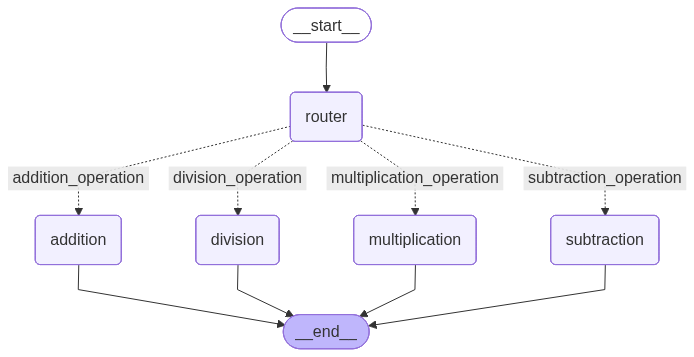

In [43]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [45]:
result = app.invoke({"num1": 23, "num2": 10, "operation": "-"})
print(result)

{'num1': 23, 'num2': 10, 'operation': '-', 'result': 13}


In [46]:
result = app.invoke({"num1": 23, "num2": 10, "operation": "/"})
print(result)

{'num1': 23, 'num2': 10, 'operation': '/', 'result': 2.3}
